In [1]:

import pandas as pd
import numpy as np
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 200)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def df_stats(df):
    from tabulate import tabulate
    print("\n***** Shape: ", df.shape," *****\n")
    
    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()
    
    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=['Name', 'Null', 'Unique', 'Dtypes'])
    print(tabulate(df_stat_val, headers='keys', tablefmt='psql'))
    return df.head()

/tmp/ipykernel_3201818/3295288443.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
df = pd.read_csv('analysis_results_notebook_refactored/k0ohoagn_20250518-173942_val_epoch15.csv')

In [23]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd # Added for type checking and NaN handling
import numpy as np  # Added for type checking

def plot_middle_frames(df, iloc, columns_to_display=None):
    """
    Plots the middle frame of video files specified in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing video file information.
                           Expected to have a 'FileName' column with semicolon-separated paths.
        iloc (int, list, np.ndarray, pd.Series, pd.RangeIndex, slice): 
                               Integer position(s), list-like object of integer positions, 
                               or a slice for rows in the DataFrame.
        columns_to_display (list, optional): List of column names from df whose values
                                             should be displayed in the title of each plot.
                                             Defaults to None.
    """
    
    file_list = []
    row_indices_for_files = [] # Stores the original DataFrame iloc for each file

    # Standardize iloc to be a list of integer positions
    processed_ilocs = []
    if isinstance(iloc, (int, np.integer)): # Handles single integer
        processed_ilocs = [int(iloc)] # Ensure it's a basic Python int
    elif isinstance(iloc, slice): # Handles slice objects
        # Resolve slice to actual integer indices based on DataFrame length
        start = iloc.start if iloc.start is not None else 0
        stop = iloc.stop if iloc.stop is not None else len(df)
        step = iloc.step if iloc.step is not None else 1
        processed_ilocs = list(range(start, stop, step)) # Produces list of Python ints
    elif isinstance(iloc, (list, np.ndarray, pd.Series, pd.RangeIndex)): # Handles list-like objects
        potential_indices = []
        if hasattr(iloc, 'tolist'): # Covers pd.Series, np.ndarray, pd.RangeIndex which have .tolist()
            potential_indices = iloc.tolist()
        elif isinstance(iloc, list): # Covers Python list
            potential_indices = iloc
        else: 
            # Fallback for other array-like types if np.ndarray wasn't caught by hasattr (should be)
            try:
                potential_indices = list(iloc)
            except TypeError:
                print(f"Error: iloc type {type(iloc)} could not be converted to a list of indices. Please provide a supported type.")
                return


        for i_val in potential_indices:
            try:
                # Ensure it's a valid integer index.
                # int() handles Python ints, np.int64, etc., and raises error for non-int-convertible.
                val_as_int = int(i_val)
                # Check if a float was passed and got truncated, which is usually not desired for indexing.
                if val_as_int != i_val and isinstance(i_val, (float, np.floating)): 
                     print(f"Warning: Float value {i_val} in iloc was truncated to {val_as_int}. Using {val_as_int}.")
                processed_ilocs.append(val_as_int)
            except (ValueError, TypeError):
                print(f"Warning: Value '{i_val}' (type {type(i_val)}) in iloc input cannot be converted to an integer. Skipping.")
    else:
        print(f"Error: iloc type {type(iloc)} is not supported. Please provide an integer, list/array of integers, slice, pd.Series, or pd.RangeIndex.")
        return

    if not processed_ilocs:
        print("Error: No valid integer row positions derived from iloc input.")
        return

    # Populate file_list and row_indices_for_files
    for row_iloc_position in processed_ilocs:
        try:
            if not (0 <= row_iloc_position < len(df)):
                print(f"Error: Resolved iloc {row_iloc_position} is out of bounds for DataFrame of length {len(df)}. Skipping.")
                continue

            filenames_str = df['FileName'].iloc[row_iloc_position]

            if pd.isna(filenames_str):
                print(f"Warning: Filename entry is NaN at iloc {row_iloc_position}. Skipping.")
                continue
            if not isinstance(filenames_str, str):
                print(f"Warning: Expected a string for filenames at iloc {row_iloc_position}, but got {type(filenames_str)} (value: '{filenames_str}'). Skipping.")
                continue
            
            current_files = [f.strip() for f in filenames_str.split(';') if f.strip()]
            if not current_files:
                # This can be common if a row legitimately has no files, so a warning might be too noisy.
                # print(f"Info: No files found after splitting filenames string at iloc {row_iloc_position}: '{filenames_str}'")
                pass

            file_list.extend(current_files)
            row_indices_for_files.extend([row_iloc_position] * len(current_files))

        except Exception as e:
            print(f"Unexpected error processing filenames for iloc {row_iloc_position}: {e}")

    if not file_list:
        print("No video files found for the provided iloc(s) or specified filenames were invalid.")
        return
    
    n_files = len(file_list)
    n_cols = min(3, n_files)
    n_rows = (n_files + n_cols - 1) // n_cols
    
    if n_files == 0:
        print("No files to plot.") # Should be caught by the check above
        return

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
    axes = axes.flatten()
    
    for idx, file_path in enumerate(file_list):
        if idx >= len(axes):
            print(f"Warning: More files ({n_files}) than available subplots ({len(axes)}). Skipping remaining files.")
            break
            
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error opening video file: {file_path}")
            axes[idx].set_title(f'Error opening\n{file_path.split("/")[-1]}', color='red', fontsize=9)
            axes[idx].axis('off')
            continue
            
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            print(f"Warning: Video file has 0 frames: {file_path}")
            axes[idx].set_title(f'0 Frames\n{file_path.split("/")[-1]}', color='orange', fontsize=9)
            axes[idx].axis('off')
            cap.release()
            continue

        middle_frame_pos = total_frames // 2
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_pos)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(frame_rgb)
            
            title_parts = [f'Video {idx+1}', file_path.split("/")[-1]]
            if columns_to_display:
                current_row_idx = row_indices_for_files[idx]
                for col in columns_to_display:
                    if col in df.columns:
                        try:
                            value = df[col].iloc[current_row_idx]
                            title_parts.append(f'{col}: {value}')
                        except IndexError:
                            title_parts.append(f'{col}: <N/A - Index Error>')
                        except Exception as e:
                            title_parts.append(f'{col}: <N/A - {type(e).__name__}>')
                    else:
                        title_parts.append(f'{col}: <N/A - No such column>')
                        
            axes[idx].set_title('\n'.join(title_parts), fontsize=9)
            axes[idx].axis('off')
        else:
            print(f"Error reading middle frame from video: {file_path}")
            axes[idx].set_title(f'Frame Read Error\n{file_path.split("/")[-1]}', color='red', fontsize=9)
            axes[idx].axis('off')

        cap.release()
    
    for i in range(n_files, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


Found 12 rows with non-null mid LAD IFR values


,FileName,mid_rca_IFRHYPEREMIE,predicted_mid_rca_IFRHYPEREMIE
576,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2019/2.16.124.113611.1.118.1.1.5339628_1.3.46.670589.28.265405998058.20191113200246693893.2.2.dcm.avi,0.96,1.00
688,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2020/2.16.124.113611.1.118.1.1.5504701_1.3.12.2.1107.5.4.5.135214.30000020060809321925000001074.dcm.avi,0.94,0.99
1373,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024/1.3.12.2.1107.5.4.5.135214.30000024030519583071100010446.512.mp4,0.92,0.94
1456,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024/1.3.46.670589.29.1877192777354251337294987019467801009081759030.mp4,0.95,0.96
1522,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2019/1.3.46.670589.28.371150851010720191210133813286770_1.3.46.670589.28.3711508510107.20191210142932644041.2.2.dcm.avi,0.94,0.91
1898,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2018/2.16.124.113611.1.118.1.1.5031735_1.3.46.670589.28.3711508510107.20181015150600915443.2.2.dcm.avi,0.84,0.89
1910,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2018/2.16.124.113611.1.118.1.1.5046594_1.3.46.670589.28.265405998058.20181101195128637863.2.2.dcm.avi,0.97,0.97
2313,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2021/2.16.124.113611.1.118.1.1.5714892_1.3.12.2.1107.5.4.5.135214.30000021020623130087900000342.dcm.avi,1.00,1.00
2738,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2023/2.16.124.113611.1.118.1.1.6486049_1.3.12.2.1107.5.4.5.135214.30000023051610313840600000581.dcm.avi,0.96,1.00
2773,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2023/2.16.124.113611.1.118.1.1.6551026_1.3.46.670589.29.1877192777354251333435876857368692.dcm.avi,0.89,0.95


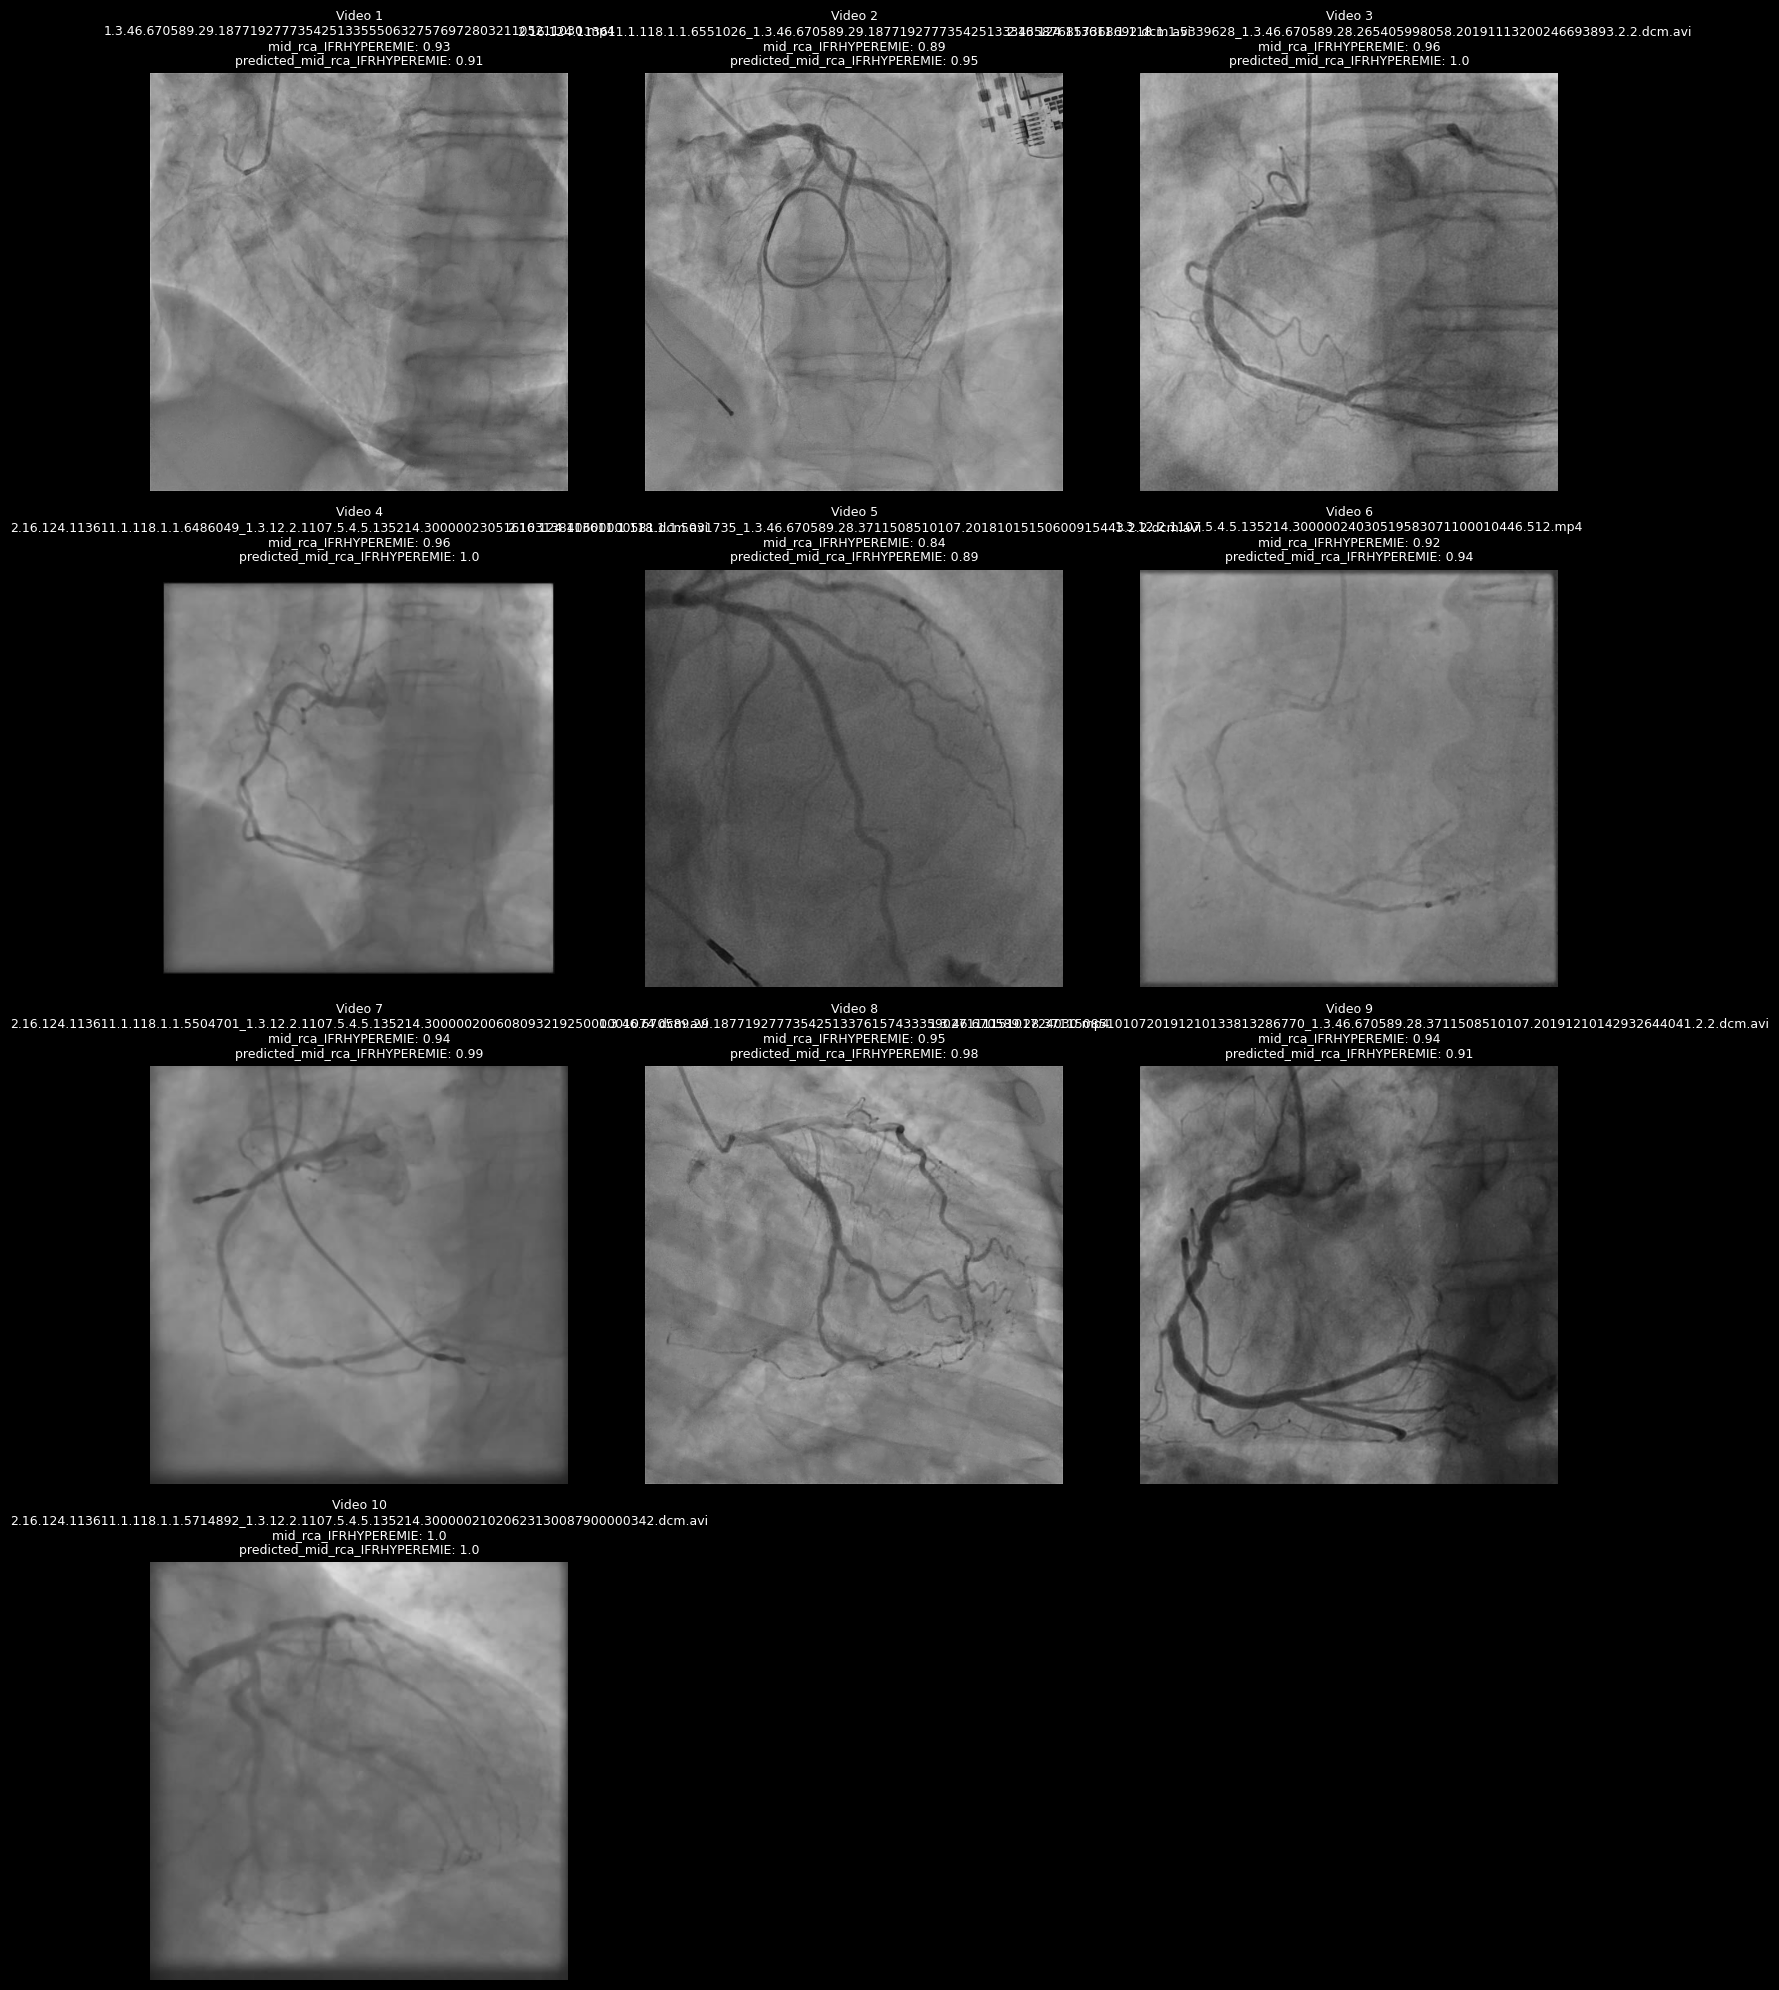

In [26]:
# Filter rows where both mid_rca_IFRHYPEREMIE and predicted_mid_rca_IFRHYPEREMIE are not null
filtered_df = df[df['mid_rca_IFRHYPEREMIE'].notna() & df['predicted_mid_rca_IFRHYPEREMIE'].notna()]
print(f"Found {len(filtered_df)} rows with non-null mid LAD IFR values")

# Display the filtered rows
display(filtered_df[['FileName', 'mid_rca_IFRHYPEREMIE', 'predicted_mid_rca_IFRHYPEREMIE']])

# Sample 10 videos and plot them
if len(filtered_df) > 0:
    sampled_df = filtered_df.sample(n=min(10, len(filtered_df)), random_state=42)
    # Reset index to avoid KeyError when accessing FileName
    sampled_df = sampled_df.reset_index(drop=True)
    # Pass the sampled dataframe index instead of length
    plot_middle_frames(sampled_df, sampled_df.index, columns_to_display=['mid_rca_IFRHYPEREMIE', 'predicted_mid_rca_IFRHYPEREMIE'])
else:
    print("No videos to plot - no rows match the criteria")